In [165]:
import numpy as np
import pandas as pd
import os

In [166]:
data_path = "./dane/"
df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')

In [167]:
# wartość optymalizacji po poszczególnym ruchu
optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
Neighbours_count = 20
improvements = np.zeros(Neighbours_count)
np.random.seed(42)

In [168]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def get_KR(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def neighbours(idx, N = Neighbours_count, df = df):
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def calculate_improvements(KR_before, idx, neighbours, df = df):
    for neighbour, improvement in zip(
        neighbours, 
        np.nditer(improvements, op_flags = ['readwrite'])
    ):
        swap(idx, neighbour)
        improvement[...] = np.float64(get_KR() - KR_before)
        swap(idx, neighbour)
        
def search_for_the_best_neighbour(neighbours):
    global improvements
    if improvements.min() > 0:
        return False
    idx_min = improvements.argmin() # index najmniejszego elementu
    return neighbours[idx_min]

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    global tabu, optimalization
    swap(idx_1, idx_2) # ruch
    
def plot_optimalization():
    global optimalization
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")

In [171]:
# liczba iteracji
number_of_iterations = 1000
# losowy początkowy indeks
idx = np.random.randint(len(df))
# jeżeli przez 1% iteracji nie poprawi się wynik to optymalizacja powinna sie zatrzymać
break_counter = number_of_iterations//100 

while number_of_iterations and break_counter:
    KR_before = get_KR() # początkowa wartość kombinacji
    Neighbours = neighbours(idx) # lista sąsiadów
    # obliczanie potencjalnych ulepszeń dla sąsiadów
    calculate_improvements(KR_before, idx, Neighbours)
    # wyszukanie sąsiada dla którego ulepszenie będzie największe
    best_neighbour = search_for_the_best_neighbour(Neighbours)
    
    # jeżeli istnieje sąsiad po zamianie z którym ulepszymy kombinacje
    if best_neighbour:
        # zamiana miejscami z sąsiadem
        move(idx, best_neighbour)
        # obliczanie obecnej kombinacji
        KR_now = get_KR()
        # kolejna iteracja rozpoczyna się od miejsca na które wskoczył idx
        idx = best_neighbour  
        # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
        optimalization = optimalization.append({"Wartosc kombinacji": KR_now}, ignore_index=True)
        number_of_iterations -= 1
    else:
        break_counter -= 1
    
    

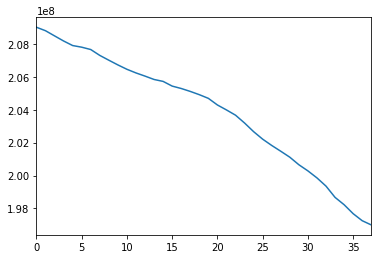

In [172]:
# działa ale bardzo słabo optymalizuje
plot_optimalization()

In [162]:
optimalization["Wartosc kombinacji"]

0     208704328
1     208553291
2     208329577
3     207926679
4     207624881
5     207306593
6     206830067
7     206304755
8     205848153
9     205502643
10    205140099
11    204750267
12    204308181
13    203675973
14    203513659
15    203024992
16    202464960
17    202020211
18    201489711
19    201136385
20    200810000
21    200535759
22    200535051
23    200111993
24    199851595
25    199758754
26    199758754
27    199633729
28    199356150
29    199027342
30    198915147
31    198708587
32    198412818
33    197962776
34    197696656
35    197301346
36    197018098
37    196740914
38    196689338
39    196688329
40    196674571
41    196471283
42    196470232
43    196470232
44    196470232
Name: Wartosc kombinacji, dtype: object